---
# <div align="center"> Final Project: Facial Keypoints Detection</div>

<div style="font-weight:bold" align="center">Nishanth Nair</div> 
<div align="center">nishanth@ischool.berkeley.edu</div> 
<div style="font-weight:bold" align="center">David Huber</div> 
<div align="center">dhuber@ischool.berkeley.edu</div> 
<div style="font-weight:bold" align="center">Jeffrey Hsu</div> 
<div align="center">jeffrey.hsu@ischool.berkeley.edu</div> 

---

## Introduction 

This report is our final submission towards the W207 project. This aims to detail the approach we have taken towards predicting facial keypoints as part of the Facial keypoint detection challenge on Kaggle.

The objective of this task is to predict keypoint positions on face images using a given set of training images.

Accuracy is evaluated on the root mean squared error. RMSE is very common and is a suitable general-purpose error metric. Compared to the Mean Absolute Error, RMSE punishes large errors:



$$ RMSE = \sqrt{\frac{1}{n}. \sum_{i=1}^{n}{(y_i - \hat{y_i})^2}} $$

At a very high level, the approach we have taken as well as the organization of this report can be broken down into a few steps.First, we perform some preprocessing on the training data to augment the dataset we have.Next, we explore various network architectures and optimization techniques and compare performance for each approach.Finally, we explore the use of ensembles and weighted averaging as a means to leverage the intricacies of these various models.

## Development Environment

The development environment was setup as follows:
- AWS g2.2xlarge instances 
    - 8
    - 15
    - 1 x 60 (SSD)
    - 1 Nvidia GRID K520 4GB (GPU)
    - cost: $0.65 per hour
- Ubuntu 14.04
- CuDNN 5.11
- Cuda 8.0
- Theano 0.9.0
- Keras 2.02

The initial setup used Theano but not Keras. Theano quickly proved to be slow to develop and customize and the documentation was often unhelpful. Keras has a large body of support online for troubleshooting errors and provided the ability to quickly try new models. This strength, along with a clear and intuitive methodology for customization, led to our adoption of Keras.

Keras allows for a Google Tensorflow or a Theano backend. We found that when backed by Tensorflow the performance was drastically reduced when measuring time per epoch on many models. Theano was the clear winner for this hardware configuration.

The setup of this environment was very time consuming because of various dependency issues. Ultimately, the simplest (though not entirely straightforward) method was to use Anaconda's installer for everything.

## Report Outline 


- **Section I: Data Augmentation**                   
    - Overview
    - Image Reflection
    - Image Blurring
    - Image Rotation                                
    - Removing badly labelled data


- **Section II: Model Architectures Explored**
    - Overview
    - Baseline Model : 2 Layer Neural Net           
    - Arch 1: 3 Layer LeNet                        
    - Arch 2: 4 layer LeNet                        
    - Arch 3: 5 Layer LeNet


- **Section III: Parameter Tuning, Optimization Techniques & Performance Improvements**
    - Activation Functions
        - ReLU                                     
        - Maxout Layers
        - S Shaped ReLU                            
    - Dynamic Learning Rate
        - Changing Learning Rate by Epoch          
        - Reducing Learning rate on Plateau        
    - Momentum Based Stochastic Gradient Descent
        - Nesterov
        - Dynamic Momentum
    - Early Stopping                               
    - Dropout
    - Weights Initialization
        - Glorot Uniform Initilaization
        - Pre-Training                             
    - Generation of specialist models             
    - Ensembles                                    


- **Section IV: Details of Models Tested**
    - Model 1: 3 Layer LeNet + Pretraining + No data augmentation                                    
    - Model 2: 4 Layer LeNet + No Pretraining + No data augmentation
    - Model 3: 4 Layer LeNet + Pretraining + No data augmentation
    - Model 4: 3 Layer LeNet + Pretraining + Data Augmentation (Blur, reflection)
    - Model 5: 3 Layer LeNet + Pretraining + Data Augmentation (Blur, reflection) + Maxout Activation
    - Model 6: 3 Layer LeNet + Pretraining + SReLU + Data Augmentation (Blur, reflection,rotation)
    - Model 7: 5 Layer LeNet + No Pretraining + No data augmentation


- **Section V: Results and Summary**
    - Performance comparison                      


- **Section VI: Conclusion**                      

In [21]:
%matplotlib inline

import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
import myhelper as helper
import conv_net_helper as cnn_helper

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler, EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

from collections import OrderedDict
from six.moves import cPickle

import pydot
import h5py

## I. Data Augmentation  

### Overview

In the given dataset, we see that the keypoints are not consistently labelled for all of the training data.We use a variety of image processing techniques to help increase the size of our dataset as well as to provide better generalization for the models.In this section, we detail the steps taken for various pre-processing techniques at train time.

### 1. Image Reflection(Flipping)

In this approach, we horizontally flip the image as well as the coordinates of the labelled facial keypoints increasing the size of our dataset at train time.

Loading data.....
Loading data.....Done


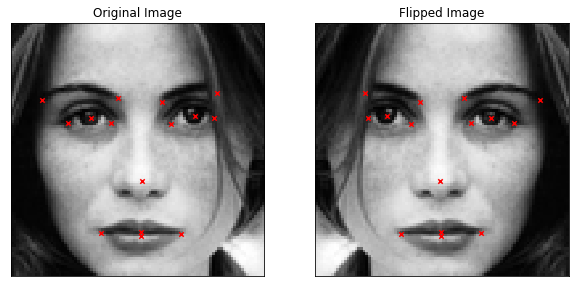

In [2]:
def generate_flip():
    def flip_image(X,y):
        flip_indices = [
            (0, 2), (1, 3),
            (4, 8), (5, 9), (6, 10), (7, 11),
            (12, 16), (13, 17), (14, 18), (15, 19),
            (22, 24), (23, 25),
            ]

        X = X[:, :, ::-1]
        y[::2] = y[::2] * -1
        for a, b in flip_indices:
            y[a], y[b] = (y[b], y[a])
        return X,y  
    
    image_index = 7    
    X,y = helper.load2d()
    X_orig,y_orig =X[image_index][0:1],y[image_index] 
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    ax.set_title('Original Image')
    helper.plot_sample(X_orig,y_orig, ax)
    X_flip,y_flip = flip_image(X_orig,y_orig)
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    ax.set_title('Flipped Image')
    helper.plot_sample(X_flip,y_flip, ax)
    plt.show()
    
generate_flip()    

The process we follow during training is as follows:
1. We pass in a batch of images to our model.
2. The model randomly chooses a set of indices from the batch of images and flips them.
3. We then train the model with the input batch + the newly generated flipped images.

With this approach, we augment our data with additional images generated at random during the training phase.

### 2. Image Blurring 

In this approach, we add a gaussian blur to the image with a $\sigma$ value of 1.
In some of our models, we blur the entire training data and evaluate the performance using this data.



Loading data.....
Loading data.....Done
Loading data.....
Loading data.....Done


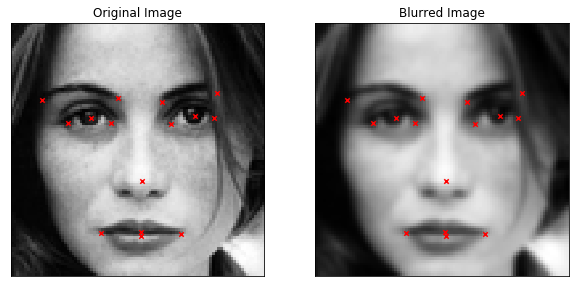

In [3]:
def generate_blur():
    image_index = 7
    X_orig,y_orig = helper.load2d(blur=False)
    X_blur,y_blur = helper.load2d(blur=True)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    ax.set_title('Original Image')
    helper.plot_sample(X_orig[image_index][0:1],y_orig[image_index], ax)
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    ax.set_title('Blurred Image')
    helper.plot_sample(X_blur[image_index][0:1],y_blur[image_index], ax)
    plt.show()
    
generate_blur()

### 3. Image Rotation

Rotate the image by $\theta$ degrees

In [4]:
from math import sin,cos,pi
from scipy.ndimage import rotate

def rotate_keypoints(X,y,theta):
    centre=0.5*np.array(X.shape)
    a=theta*pi/180.0
    
    ox = centre[0]
    oy = centre[1]
    px = y[0::2] * 48 + 48, 
    py = y[1::2] * 48 + 48
    
    qx = ox + cos(a) * (px - ox) - sin(a) * (py - oy)
    qy = oy + sin(a) * (px - ox) + cos(a) * (py - oy)    

    final = np.empty((qx.size + qy.size,), dtype=qx.dtype)
    final[0::2] = (qx-48)/48
    final[1::2] = (qy-48)/48 
    return final
    
def rotate_img(X,y,theta):
    image = rotate(X, theta, reshape=False,mode='nearest')
    labels = rotate_keypoints(X,y,-theta)
    return image,labels

Loading data.....
Loading data.....Done


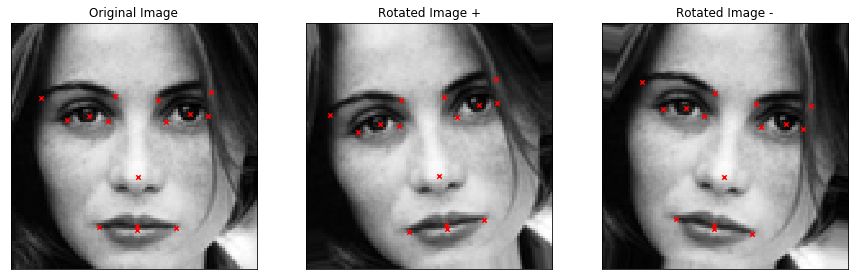

In [5]:
def test_rotate(theta = 5):
    image_index = 7
    X,y = helper.load2d(blur=False)
    
    X_orig,y_orig = X[image_index][0:1],y[image_index] 
    X_rotate_C,labels_C = rotate_img(X_orig[0],y_orig,theta)
    X_rotate_A,labels_A = rotate_img(X_orig[0],y_orig,-theta)
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    ax.set_title('Original Image')
    helper.plot_sample(X_orig,y_orig, ax)
    ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    ax.set_title('Rotated Image +')
    helper.plot_sample(X_rotate_C,labels_C, ax)
    ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    ax.set_title('Rotated Image -')
    helper.plot_sample(X_rotate_A,labels_A, ax)
    plt.show()
    

test_rotate(theta = 10)

### 4. Bad Labelled Data 

Loading data.....
Loading data.....Done


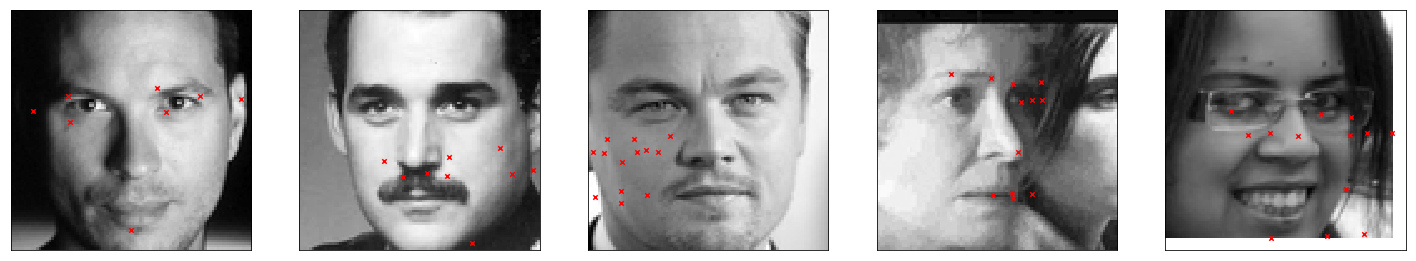

In [6]:
def plt_bad_data():
    image_indices = [1747, 1877, 1907, 2090, 2199]
    X,y = helper.get_all_images()
    fig = plt.figure(figsize=(25,25))
    for i in range(len(image_indices)):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        helper.plot_sample(X[image_indices[i]][0:1],y[image_indices[i]], ax)
    plt.show()
    
plt_bad_data()

## II. Model Architectures Explored

### Overview

In this section, we explore the various architectures we used to compare preformance on the test data.

### Baseline Model

In out initial baseline model, we used a simple 2 layer neural network with sigmoid activation in the hidden layer to train the data.This model had 300 nodes in the hidden layer and was trained for 150 epochs.

The architecture used is as depicted below:

<img src='images/baseline.png'width="700" align="left">

Please refer the doc [final_project_nair_huber_hsu.ipynb](https://github.com/nishanth01/W207_Final_Project/blob/master/final_project_nair_huber_hsu.ipynb) for more details on the baseline model.

### Arch 1: 3 Layer LeNet 

In our first architecture, we use the LeNet architecture consisting of 3 layers of alternating convolution and max pool layers followed by 2 fully connected layers having 500 nodes each.

Below is a representation of the architecture used.In section III, we detail the various optimizations used with the architecture.

<img src='images/model1_arch.png' width="500" align="left">

### Arch 2: 4 Layer LeNet

In this model, we again use the LeNet Architecture but add an additional convolution and max pool layer as depicted below.

Another difference here is that instead of training one model for all outputs, we train different models for different keypoints. More details on this in section IV.

Architecture is same for all models except for the output layer.

<img src='images/model2_arch.png' width="500" align="left">

### Arch 3: 5 Layer LeNet

With model 4, we continue using the LeNet Architecture. Additional convolutional layers and dense connected layed are added. In total there are 5 convolutional layers for feature extraction and 5 dense layers for getting the final output. Each convolutional layer comes with pooling for reducing number of parameters and dropout for avoiding overfitting.

Similar to model 2, instead of training one model for all outputs, we trained different specialized CNN models for different keypoint sets. The example below depicts a CNN built for capturing the 4 eye corners keypoints, thus the ouput is with shape 4. At prediction time, each CNN for different set of keypoints generate the predicted position of keypoints and results are validated together.

<img src='images/model4_arch.png' width="700" align="left">

## III. Parameter Tuning , Optimization Techniques & Performance Improvements

### Activation Functions

#### 1. ReLU - Rectified Linear Unit

In most of our models, we use the Rectifier Activation as the non-linearity for most layers which is defined as 

$$f(x) = x^+ = max(0,x)$$


In our experiments, we notice that using ReLU increases rate of convergence as opposed to sigmoid activation and we get better generalization as well. A typical representation of this activation is as below:

<img src='images/relu.png'>

#### 2. Maxout Layers

$$ f(x) = x^+ = max([x_1, x_2, \dots, x_n]) \> ; \>\text{where $x$ is a hidden layer} $$


<img src='images/maxout.png'>
<img src='images/maxout_layer.png'>
<div align="center">$v$ inputs, $z$ neurons per $h$ hidden layer, with maximum taken in $g$</div>

Maxout activation is implemented with a sub-network of hidden layers rather than a function. A maxout layer trains multiple layers in parallel and then takes the max of each learned weight across those layers. This is effectively max pooling across features rather than feature neighborhoods. Maxout activation can be interpreted as making a piecewise linear approximation to an arbitrary convex function to learn the best activation function for the particular task at hand (graphical depiction above on top). It address the problem of neuron saturation by being bounded from neither above nor below. A potential drawback is that there are $n$ times as many neurons per layer, where $n$ is the width of the maxout sub-network.

#### 3. S-Shaped ReLU

One reason we examine the use of sReLU is that none of the other activation functions(relu,leaky relu, parametric relu,maxout,sigmoid) can learn non convex functions since they are primarily convex functions.

Some of the documented advantages of this activation are as folows:
- Learns both convex and non convex functions without imposing restrictions on learning parameters
- Since it utilizes piecewise linear functions rather than saturated functions it does not suffer from the “exploding/vanishing gradient” problem and has high computational speed during the forward and backpropagation of deep networks.



<img src='images/srelu.png'>

### Dynamic Learning Rates

We notice that with a fixed learning rate, training takes a lot of time and beyond a certain point, the network stops learning or generalizing.The learning rate is critical for getting the best performance out of a network.
If the rate is too small, we fail to converge or will take too long and if its too large, results could start diverging. To address this, we use the following techniques to optimize our learning.

<img src='images/learning_rates.png'>

#### 1. Changing Learning Rate by Epoch

We use the LearningrateScheduler provided by Keras to change the learning rate dynamically per epoch.
We start with a high value and as training progresses, we keep decrementing the learning rate.The intiution behind this is that initially, we are far away from our target and take large steps toward the target, but as we reach closer, we take smaller steps by decresing the learning rate.

```
learning_rates = np.linspace(start, stop, epochs)
change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
```

#### 2. Reducing Learning rate on Plateau


Keras provides a call back we can use to reduce the learning rate once learning stagnates.In our tests, we monitor the validation loss and reduce the learning rate by a small factor if its been stagnant for n epochs.

```
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001,patience=30, min_lr=stop)
```

### Momentum Based Stochastic Gradient Descent

#### Standard Momentum

Momentum is added to standard SGD to assist in moving more quickly across shallower parts of the objective function. Instead of just the negative gradient, it uses the sum of the negative gradient and the weighted update from the previous update. The weight is a hyperparameter.

#### Nesterov Momentum

Instead of taking the sum of the negative gradient and momentum based on the previous update, Nesterov momentum applies the momentum term first and then takes the gradient at that "look-ahead" position. Then, as before, the negative of this gradient is summed with the weighted most recent update. Nesterov Momentum provides stronger convergence guarantees for convex functions. After early testing with many paremeter update methods, Nesterov momentum consistently surfaced as the most fruitful and was used in nearly all models tested.

<img src='images/nesterov.jpeg'>

### Dynamic Momentum

#### 1. Changing Momentum by Epoch

Keras does not provide a direct way to change the momentum parameter dynamically per epoch so we wrote a callback function that extends the base Keras callback class based on the code of the built in LearningRateScheduler. In a similar fashion, we started at a modest value for momentum, and then increased it towards a very high value as the epochs progressed. This is especially useful to keep convergence moving as the learning rate dynamically decreases and the process approaches the minimum.

```
class MomentumScheduler(Callback):
    
    def __init__(self, schedule):
        super(MomentumScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs={}):
        assert hasattr(self.model.optimizer, 'momentum'), \
            'Optimizer must have a "momentum" attribute.'
        momentum = self.schedule(epoch)
        assert type(momentum) == float, 'The output of the "schedule" function should be float.'
        self.model.optimizer.momentum.set_value( momentum)
```
```
momentum_rates = np.linspace(mom_start, mom_stop, epochs)
change_mom = MomentumScheduler( lambda epoch: float(momentum_rates[epoch]))
```

### Dropout

<img src="images/dropout1.png">

Dropout is a technique that, during training, each neuron's output is dropped (set to 0) randomly with probability $p$. So on each epoch, a subset of the full model is trained, and on the next epoch a different subset is randomly chosen for training. This has the effect of training an ensemble of models and producing an approximate average model. Dropout is a simple and effective way to introduce regularization that helps prevent overfitting. Dropout paired with Maxout activation has been shown to generalize quite well, and they are frequently used together.

### Early Stopping

The idea behind early stop is to monitor the validation and training loss and stop training when the gap starts to widen thus preventing overfitting and getting a model that is better generalized.

Keras provides a callback to manage Early stopping.

```
early_stop = EarlyStopping(monitor='val_loss',patience=100)
```

<img src="images/early_stop.png">

### Weights Initialization

#### 1. Glorot Uniform Initialization

Glorot uniform style initialization draws samples from a uniform distribution within $[-limit,limit]$

where: $$limit = \sqrt{\frac{6}{fan\_in + fan\_out}}$$
and $fan\_in$ and $fan\_out$ are the number of input and output units to the layer, respectively.

#### 2. Pre-Training \ Transfer Learning

For all of our models, we first train a base model initialized by Glorot uniform or some other initilizer and persist the model after training.We then build specialist models with weights initilized from the pretrained models.

Some of the advantages we see with this approach are as follows:

- Better convergence and fine tuning of weights
- Faster training for specilists since they converge faster
- In many cases, we see training stop early because of the early stopping rules we set.
- We also use smaller training rates for the specialist training.

<img src="images/pretrain_compare.png">

### Generation of specialist models

When we analyze the data we see that out of the 7000 samples provided, only around 2000 have all keypoints labelled.
If we train a single model for all the keypoints, we would not be using over 70% of the data. To overcome this, we create seperate models for sets of keypoints giving us better performance while predicting on the test set.

We create 6 specialists for the 30 keypoint coordinates as follows:



<img src="images/specialists_table.png" width="500" align="left">

### Ensembles

Eventhough we have specialists for the keypoints, we use different techniques to train various models.So essentially different models are learning different features from the training datasets.This gives us an opportunity to experiment with an ensemble of models and determine how the ensemble works as opposed to each independent model.

We use the best models we have to create an ensemble of specialists and use the weighted average of their scores to determine the final prediction on the test set.

We follow the following process to create and use the ensembles:

- **STEP 1: Assigning a score to each model**

Here, we use two scores to determine the weight assigned to each model.One, we use the validation score on the dev set and the final kaggle score for the given model.(**Note**: All specialists are assigned the same kaggle score).
This process is depicted below:

<img src="images/ensemble_step1.png" width="500" align="left">

- **STEP 2: Determine model weight and specialist weight**

Rather than using a linear weight strategy, we use an exponential weighting strategy. 
For example improving the score from 1.9 to 1.6 is much tougher than moving from 2.3 to 1.9.And we account for this difference in points by using an exponential function.So the idea is that specialists performing better get a much higher weight than those performing worse.

We compute two weights based on the scores collected for each ensemble:
     - Feed in model scores to get a weight per base model
     - Compute the specialist weight based on the specialist scores.

- **STEP 3: Final Prediction**

For the final prediction, we assign a weight of 0.6 to the model weight since its based on kaggle scores and a weight of 0.4 to the specialist weights since its based on training data and use the final weight to compute a weighted average of the predicted values across the ensembles.This final value is used as our prediction for the test set.

## IV. Details of Models Tested

### Model 1:  3 Layer LeNet + Pretraining + No data augmentation

In this model, we use 3 alternating convolution layers followed by a fully connected layer with 500 nodes each.
All nodes use the rectified linear activation function.
We use the given training data with no data augmentation or prerpocessing.
We use nesterov momentum optimizer, set early stop with a patience of 100 epochs and use a batch size of 128.

We first train our base model as follows:

In [7]:
def execute_pretrain_model(epochs=1000):
    start = 0.03
    stop = 0.001
    batch_size = 128
    
    dropout1 = 0.1
    dropout2 = 0.2
    dropout3 = 0.3
    dropout4 = 0.4
    
    X, y = helper.load2d()
    train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,y)
    
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', data_format = 'channels_first', input_shape=(1,96, 96)))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout1)) 

    model.add(Conv2D(64, (2, 2), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout2)) 

    model.add(Conv2D(128, (2, 2), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout3)) 

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(dropout4)) 
    model.add(Dense(500, activation='relu'))
    model.add(Dense(30))

    sgd = SGD(lr=start, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    
    early_stop = EarlyStopping(patience=100)
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    
    data =  model.fit(train_data, train_labels, 
                       batch_size = batch_size,
                       epochs=epochs, 
                       validation_data=(dev_data, dev_labels),
                       callbacks=[change_lr, early_stop])
    
    helper.plot_model_performance(data)
    helper.get_error(model,dev_data, dev_labels)
    helper.save_model(model,"pretrain_model")
    return model

We see the following results for the base model

<img src="images/model1_base_results.png">

Once we have the pre trained model, we train specialists for each keypoint using this pretrained model.
This is done as follows:

In [8]:
def train_specialist(cols,epochs = 1000,start = 0.01,stop = 0.001,
                     prefix = 'specialist_model',
                     batch_size = 128,
                     saved_model = None):
    
    print 'Training model for columns {0} for {1} epochs'.format(cols, epochs)
    X, y = helper.load2d(cols=cols)
    train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,y)
    model_name = '{0}_{1}'.format(prefix,cols[0])
    
    use_pre = True
    if saved_model is not None:
        if os.path.isfile(saved_model):
            print 'Weights saved...'
            use_pre = False
        else:
            print 'NO Saved weights'
    else:
        print 'NO Saved weights'
        
    
    model = helper.retrieve_model('pretrain_model',weights=use_pre)
    helper.pop_layer(model)
    model.add(Dense(len(cols),name=cols[0]))
    if not use_pre:
        print 'Loading saved weights...'
        model.load_weights(saved_model)
        
    sgd = SGD(lr=start, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)

    early_stop = EarlyStopping(monitor='val_loss',patience=100)
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    
    path = model_name+"_weights_epoch-{epoch:02d}.h5"  
    check_point = ModelCheckpoint(path,period=100,verbose=1) 

    data =  model.fit(train_data, train_labels, 
                      batch_size = batch_size,
                      epochs=epochs, 
                      validation_data=(dev_data, dev_labels),
                      callbacks=[change_lr, early_stop])#,check_point

    helper.save_model(model,model_name)
    helper.plot_model_performance(data)
    helper.get_error(model,dev_data, dev_labels)
    return model    

We use the following settings for each specialist and persist the resulting model.

In [9]:
def sample_code_1():
    cols = helper.SPECIALIST_SETTINGS[0]['columns']
    prefix = 'specialist_model'
    start = 0.01
    stop = 0.001
    batch_size = 64
    epochs = 1000
    last_saved = None#'specialist_model_left_eye_center_x_weights_epoch-599.h5'

    train_specialist(cols,epochs,start,stop,prefix,batch_size,last_saved)

We see the following results from our first model

<img src="images/ensemble_0_results.png">

Some points to note from our first model:
    - We see better convergence in the specialists compared to the base model
    - Eventhough the base model has an error of 2.2,some of the specialists have worse scores compared to the base model.
    - We see early stops in some specialists
    - In most cases, we do see some evidence of overfitting

**NOTE**: For detailed code and execution logs refer the below:
- Base model execution notebook : [Pretrain_Model_1.ipynb](https://github.com/nishanth01/W207_Final_Project/blob/master/submission_files/notebooks/Pretrain_Model_1.ipynb)
- Specialists execution notebook: [Ensemble_0.ipynb](https://github.com/nishanth01/W207_Final_Project/blob/master/submission_files/notebooks/Ensemble_0.ipynb)

### Model 2:  4 Layer LeNet + No Pretraining + No data augmentation 

In this model, we use 4 alternating convolution layers followed by a fully connected layer with 500 nodes each.
We keep all parameters identical to our first model and have no data augmentation on the training data.

In [10]:
def train_ensemble2(cols,model_number,epochs=10):

    model_name = 'specialist_model_{0}_ensemble-{1}'.format(cols[0],model_number)
    
    start = 0.03
    stop = 0.001
    batch_size = 128
    
    dropout1 = 0.1
    dropout2 = 0.2
    dropout3 = 0.3
    dropout4 = 0.4
    dropout5 = 0.5
    
    X, y = helper.load2d(cols=cols)
    X, y = shuffle(X, y)
    train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,y)
    
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', data_format = 'channels_first', input_shape=(1,96, 96)))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout1)) 

    model.add(Conv2D(64, (3, 3), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout2)) 

    model.add(Conv2D(128, (2, 2), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout3)) 

    model.add(Conv2D(256, (2, 2), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout4)) 
    
    
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(dropout5)) 
    model.add(Dense(500, activation='relu'))
    model.add(Dense(len(cols)))

    sgd = SGD(lr=start, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    
    early_stop = EarlyStopping(patience=100)
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    
    data =  model.fit(train_data, train_labels, 
                       batch_size = batch_size,
                       epochs=epochs, 
                       validation_data=(dev_data, dev_labels),
                       callbacks=[change_lr, early_stop])
    
    helper.plot_model_performance(data)
    helper.get_error(model,dev_data, dev_labels)
    helper.save_model(model,model_name)

We directly train specialists on this model.Sample code to train as below:

In [11]:
def sample_code_2():
    cols = helper.SPECIALIST_SETTINGS[0]['columns']
    train_ensemble2(cols,model_number,epochs=3000)

The results from our training are as follows:

<img src="images/ensemble_1_results.png">

Some points to note from this model:
    - We see that the loss is choppy and that it doesn't converge very effectively.
    - The RMSE is generally higher than our first model.

**NOTE**: For detailed code and execution logs refer the below:
- Specialists execution notebook: [Ensemble_1.ipynb](https://github.com/nishanth01/W207_Final_Project/blob/master/submission_files/notebooks/Ensemble_1.ipynb)

### Model 3: 4 Layer LeNet + Pretraining + No data augmentation

This model uses model 2 as the pretrained model with every other parameter kept identical.
We don't augment data in this training.

In [12]:
def train_ensemble3(cols,model_number=2,epochs=10):

    model_name = 'specialist_model_{0}_ensemble-{1}'.format(cols[0],model_number)
    base_model_name = 'trained_models/specialist_model_{0}_ensemble-1'.format(cols[0])

    start = 0.03
    stop = 0.001
    batch_size = 128

    X, y = helper.load2d(cols=cols)
    X, y = shuffle(X, y)
    train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,y)
    
    model = helper.retrieve_model(base_model_name,weights=True)
        
    sgd = SGD(lr=start, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)

    early_stop = EarlyStopping(monitor='val_loss',patience=100)
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    
    data =  model.fit(train_data, train_labels, 
                      batch_size = batch_size,
                      epochs=epochs, 
                      validation_data=(dev_data, dev_labels),
                      callbacks=[change_lr, early_stop])

    helper.save_model(model,model_name)
    helper.plot_model_performance(data)
    helper.get_error(model,dev_data, dev_labels)
    return model    

The results of the training are as follows:

<img src="images/ensemble_2_results.png">

We see some interesting behaviour here:
    - Almost all the specialists stop early and don't learn much
    - The RMSE is generally better than both our previous models despite the low learning

**NOTE**: For detailed code and execution logs refer the below:
- Specialists execution notebook: [Ensemble_2.ipynb](https://github.com/nishanth01/W207_Final_Project/blob/master/submission_files/notebooks/Ensemble_2.ipynb)

### Model 4: 3 Layer LeNet + Pretraining + Data Augmentation (Blur, reflection)

In this model, we use a pretrained 3 layer LeNet model to train our specialists.In addition, we augment the data by blurring the images as well as randomly flipping batches of images.

To generate the flipped images, we extend the "ImageDataGenerator" class and provide an implementation for this.
The process is as follows:
- Take a batch of images
- Randomly choose indices for a subset of images
- Flip the images and add to existing dataset

This is achieved using the following code:

In [13]:
class FlippedImageDataGenerator(ImageDataGenerator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def next(self):
        X_batch, y_batch = super(FlippedImageDataGenerator, self).next()
        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size/2, replace=False)
        X_batch[indices] = X_batch[indices, :, :, ::-1]

        if y_batch is not None:
            y_batch[indices, ::2] = y_batch[indices, ::2] * -1

            for a, b in self.flip_indices:
                y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )

        return X_batch, y_batch

We then train our Base model first as depicted below:

In [14]:
def execute_pretrain_model4(epochs=1000):
    start = 0.03
    stop = 0.001
    batch_size = 32
    
    dropout1 = 0.1
    dropout2 = 0.2
    dropout3 = 0.3
    dropout4 = 0.4
    
    X, y = helper.load2d(blur=True)
    train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,y)
    
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', data_format = 'channels_first', input_shape=(1,96, 96)))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout1)) 

    model.add(Conv2D(64, (2, 2), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout2)) 

    model.add(Conv2D(128, (2, 2), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout3)) 

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(dropout4)) 
    model.add(Dense(500, activation='relu'))
    model.add(Dense(30))

    sgd = SGD(lr=start, momentum=0.9, nesterov=True,decay=1e-6)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    flipImage = FlippedImageDataGenerator()
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001,patience=30, min_lr=stop)
    
    data =  model.fit_generator(flipImage.flow(train_data, train_labels), 
                                steps_per_epoch=train_data.shape[0]/batch_size,
                                epochs=epochs, 
                                validation_data=(dev_data, dev_labels),
                                callbacks=[change_lr,reduce_lr])
    
    helper.plot_model_performance(data)
    helper.get_error(model,dev_data, dev_labels)
    helper.save_model(model,"pretrain_model_3")
    return model

The results of training the base model are as follows:

<img src="images/model_4_base_results.png">

We now train the specialists based on the pretrained base model as follows:

In [15]:
def train_ensemble4(cols,model_number=3,epochs=10,flip_indices=None):

    model_name = 'specialist_model_{0}_ensemble-{1}'.format(cols[0],model_number)
    base_model_name = 'pretrain_model_3'

    start = 0.03
    stop = 0.001
    batch_size = 64

    X, y = helper.load2d(cols=cols,blur=True)
    X, y = shuffle(X, y)
    train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,y)
    
    model = helper.retrieve_model(base_model_name,weights=True)
    helper.pop_layer(model)
    model.add(Dense(len(cols),name=cols[0]))
        
    sgd = SGD(lr=start, momentum=0.9, nesterov=True,decay=1e-6)
    model.compile(loss='mean_squared_error', optimizer=sgd)

    early_stop = EarlyStopping(patience=300)
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    
    flipImage = FlippedImageDataGenerator()
    flipImage.flip_indices = flip_indices
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001,patience=50, min_lr=stop)
    
    data =  model.fit_generator(flipImage.flow(train_data, train_labels), 
                                steps_per_epoch=train_data.shape[0]/batch_size,
                                epochs=epochs, 
                                validation_data=(dev_data, dev_labels),
                                callbacks=[change_lr, early_stop,reduce_lr])

    helper.save_model(model,model_name)
    helper.plot_model_performance(data)
    helper.get_error(model,dev_data, dev_labels)
    return model    

The results of training the specialists are as follows:

<img src="images/ensemble_3_results.png">

We notice the following from this training:
    - we seem to be getting better RMSE scores compared to other models
    - there are signs of overfitting since we incresed the early stop limit
    - We get a good learning curve for the base model

**NOTE**: For detailed code and execution logs refer the below:
- Specialists execution notebook: [Ensemble_3.ipynb](https://github.com/nishanth01/W207_Final_Project/blob/master/submission_files/notebooks/Ensemble_3.ipynb)

### Model 5:  3 Layer LeNet + Pretraining + Maxout + Data Augmentation(Blur, rotation)

In this model, we used a 3 layer LeNet like in the previous models but with 2 changes:

1. We used maxout activation
2. We used 1 fully connected layer with 1000 hidden nodes
3. Momentum was adjusted per epoch

This is achieved using the following code:

In [ ]:
def execute_pretrain_model5( epochs=1000, outFile=None):
    
    lr_start = 0.03
    lr_stop = 0.0001
    mom_start = .9
    mom_stop = .999
    batch_size = 64
    nMaxOutWidth = 2
    
    X, y = helper.load2d(blur=True)
    train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,y)
    
    modelInput = Input( shape=(1,96, 96))
    
    x= layers.maximum( [Conv2D(32, (3, 3), activation=None, padding='full', \
                               kernel_initializer=glorot_uniform())(modelInput) for _ in range( nMaxOutWidth)])
    x = MaxPooling2D( pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    x = layers.maximum( [Conv2D(64, (2, 2), activation=None, kernel_initializer=glorot_uniform())(x) \
                         for _ in range( nMaxOutWidth)])
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    x= layers.maximum( [Conv2D(128, (2, 2), activation=None, kernel_initializer=glorot_uniform())(x) \
                        for _ in range( nMaxOutWidth)])
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    maxDense = [ Dense(1000, activation=None, kernel_initializer=glorot_uniform())(x) for _ in range(nMaxOutWidth)]
    x = layers.maximum( maxDense)
    x = Dropout(0.5)(x)
        
    x = Dense(30)(x)
    
    model = Model(modelInput, x)
    
    sgd = SGD( lr=helper.float32(lr_start), momentum=mom_start, nesterov=True)
    model.compile( loss='mean_squared_error', optimizer=sgd)
    
    early_stop = EarlyStopping(patience=200, verbose=2)
    learning_rates = np.linspace(lr_start, lr_stop, epochs)
    momentum_rates = np.linspace(mom_start, mom_stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    change_mom = MomentumScheduler( lambda epoch: float(momentum_rates[epoch]))
    imageGen = ModifiedImageDataGenerator()
    
    data =  model.fit_generator( imageGen.flow( train_data, train_labels, batch_size), 
                                 steps_per_epoch=train_data.shape[0] / batch_size,
                                 epochs=epochs, 
                                 validation_data=(dev_data, dev_labels),
                                 callbacks=[ change_lr, change_mom, early_stop],
                                 initial_epoch=0)

    helper.plot_model_performance(data)
    helper.get_error(model,dev_data, dev_labels)
    helper.save_model(model, outFile)
    
    return model, data


The results of training the base model are as follows:

<img src="images/MaxoutPretrain.png">

We now train the specialists based on the pretrained base model as follows:

(One thing to note, due to the increased size of the model, several changes had to be made to keep the GPU from running out of memory. They are reflected below.)

In [ ]:
def train_ensemble5( startWeightFile, epochs=1000):
    lr_start = 0.03
    lr_stop = 0.0001
    mom_start = .9
    mom_stop = .999
    batch_size = 64
    layerName = "special_"
    layerID = 0
    
    model = helper.retrieve_model( startWeightFile, weights=False)
    
    for setting in helper.SPECIALIST_SETTINGS:
        cols = setting['columns']
        
        X, y = helper.load2d(cols=cols, blur=True)
        train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,y)
        
        model.load_weights( startWeightFile +'_weights.h5')
        
        # pop off the last layer and add on the new one - layer names must always be unique
        helper.pop_layer( model)
        newOutput = Dense(len(cols), name=layerName+str(layerID))(model.layers[-1].output)
        model = Model( model.input, newOutput)
        layerID += 1
        
        sgd = SGD(lr=helper.float32(lr_start), momentum=mom_start, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer=sgd)
        
        early_stop = EarlyStopping( patience=100)
        learning_rates = np.linspace( lr_start, lr_stop, epochs)
        change_lr = LearningRateScheduler( lambda epoch: float(learning_rates[epoch]))
        momentum_rates = np.linspace( mom_start, mom_stop, epochs)
        change_mom = MomentumScheduler( lambda epoch: float(momentum_rates[epoch]))
        imageGen = ModifiedImageDataGenerator()
        
        print 'Training model for columns {0} for {1} epochs'.format(cols, epochs)
        flipgen_batch_iter = FlipGenerator()
        imageGen.flip_indices = setting['flip_indices']
    
        data =  model.fit_generator( imageGen.flow( train_data, train_labels, batch_size), 
                                     steps_per_epoch=train_data.shape[0] / batch_size,
                                     epochs=epochs, 
                                     validation_data=(dev_data, dev_labels),
                                     callbacks=[ change_lr, change_mom, early_stop],
                                     initial_epoch=0)
        
        helper.save_model(model,'specialist_model_fullmax2_SingleDense1000_Blur_{0}'.format(cols[0]))
        helper.plot_model_performance(data)
        helper.get_error(model,dev_data, dev_labels)
                
        # set model up for next run
        helper.pop_layer( model)
        newOutput = Dense(30, name=layerName+str(layerID))(model.layers[-1].output)
        model = Model( model.input, newOutput)
        layerID += 1
        
    

We see the following results for the specialists:

<img src="images/maxout_specialists.png">

We notice the following from this training:
    - improved RMSE of specialists
    - there are signs of overfitting in some of the models maybe due to using the same dropout for each fit
    - base model has greatly improved RMSE

### Model 6: 3 Layer LeNet + Pretraining + SReLU + Data Augmentation (Blur, reflection,rotation)

In this model, we use a 3 layer LeNet like the previous models but with 2 changes.

1. We use S-shaped ReLU in the fully connected layers
2. We randomaly rotate images by 10 degrees either clockwise or anticlockwise.

For data augmentation, we use the image generator like we did in model 4.We follow the below process:

1. Take a batch of images
2. Randomly choose indices for a subset of images
3. Flip the images and add to existing dataset
4. Randomly choose indices for a subset of images
5. Rotate the images either clockwise or anticlockwise and add to existing dataset

The code is as follows:


In [16]:
class ModifiedImageDataGenerator(ImageDataGenerator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def next(self):
        X_batch, y_batch = super(ModifiedImageDataGenerator, self).next()
        X_batch, y_batch = flip_image(X_batch, y_batch)
        X_batch, y_batch = rotate_batch(X_batch, y_batch)
        
        return X_batch, y_batch

    
    def flip_batch(X_batch, y_batch):
        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size/2, replace=False)
        X_batch[indices] = X_batch[indices, :, :, ::-1]

        if y_batch is not None:
            y_batch[indices, ::2] = y_batch[indices, ::2] * -1

            for a, b in self.flip_indices:
                y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )
        return X_batch, y_batch

    def rotate_batch(X_batch, y_batch):
        theta = 10
        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size/2, replace=False)
        for i in indices:
            if i/2 == 0:
                X_batch[i][0], y_batch[i] = rotate_image(X_batch[i][0],y_batch[i],theta)
            else:
                X_batch[i][0], y_batch[i] = rotate_image(X_batch[i][0],y_batch[i],-theta)

        return X_batch, y_batch  
    
    def rotate_image(X,y,theta):
        image = rotate(X, theta, reshape=False)
        labels = rotate_keypoints(X,y,-theta)
        return image,labels

    def rotate_keypoints(X,y,theta):
        centre=0.5*np.array(X.shape)
        a=theta*pi/180.0

        ox = centre[0]
        oy = centre[1]
        px = y[0::2] * 48 + 48
        py = y[1::2] * 48 + 48

        qx = ox + cos(a) * (px - ox) - sin(a) * (py - oy)
        qy = oy + sin(a) * (px - ox) + cos(a) * (py - oy)    

        final = np.empty((qx.size + qy.size,), dtype=qx.dtype)
        final[0::2] = (qx-48)/48
        final[1::2] = (qy-48)/48 
        return final


We now train the base model as follows:

In [17]:
def execute_pretrain_model(epochs=1000):
    start = 0.03
    stop = 0.001
    batch_size = 32
    
    dropout1 = 0.1
    dropout2 = 0.2
    dropout3 = 0.3
    dropout4 = 0.4
    
    X, y = helper.load2d(blur=True)
    train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,y)
    
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', data_format = 'channels_first', input_shape=(1,96, 96)))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout1)) 

    model.add(Conv2D(64, (2, 2), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout2)) 

    model.add(Conv2D(128, (2, 2), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(dropout3)) 

    
    
    model.add(Flatten())
    model.add(Dense(500))
    model.add(SReLU())
    model.add(Dropout(dropout4)) 
    model.add(Dense(500))
    model.add(SReLU())
    model.add(Dense(30))

    sgd = SGD(lr=start, momentum=0.9, nesterov=True,decay=1e-6)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    imageGen = ModifiedImageDataGenerator()
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001,patience=30, min_lr=stop)
    
    data =  model.fit_generator(imageGen.flow(train_data, train_labels), 
                                steps_per_epoch=train_data.shape[0]/batch_size,
                                epochs=epochs, 
                                validation_data=(dev_data, dev_labels),
                                callbacks=[change_lr,reduce_lr])
    
    helper.plot_model_performance(data)
    helper.get_error(model,dev_data, dev_labels)
    model.save("pretrain_model_4.h5")
    #helper.save_model(model,"pretrain_model_4")
    return model

We see the following results for the base model:

<img src="images/model_6_base_results.png">

We now train the specialists based on our base model as follows:

In [18]:
def train_ensemble(cols,model_number=3,epochs=10,flip_indices=None):

    model_name = 'specialist_model_{0}_ensemble-{1}.h5'.format(cols[0],model_number)
    base_model_name = 'pretrain_model_4.h5'

    start = 0.03
    stop = 0.001
    batch_size = 64

    X, y = helper.load2d(cols=cols,blur=True)
    X, y = shuffle(X, y)
    train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,y)
    
    model = load_model(base_model_name)#helper.retrieve_model(base_model_name,weights=True)
    helper.pop_layer(model)
    model.add(Dense(len(cols),name=cols[0]))
        
    sgd = SGD(lr=start, momentum=0.9, nesterov=True,decay=1e-6)
    model.compile(loss='mean_squared_error', optimizer=sgd)

    early_stop = EarlyStopping(patience=500)
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    
    imageGen = ModifiedImageDataGenerator()
    imageGen.flip_indices = flip_indices
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001,patience=50, min_lr=stop)
    
    data =  model.fit_generator(imageGen.flow(train_data, train_labels), 
                                steps_per_epoch=train_data.shape[0]/batch_size,
                                epochs=epochs, 
                                validation_data=(dev_data, dev_labels),
                                callbacks=[change_lr,early_stop,reduce_lr])

    #helper.save_model(model,model_name)
    model.save(model_name)
    helper.plot_model_performance(data)
    helper.get_error(model,dev_data, dev_labels)
    return model  

We see the following results for the specialists:

<img src="images/ensemble_5_results.png">

**NOTE**: For detailed code and execution logs refer the below:
- Specialists execution notebook: [Ensemble_4.ipynb](https://github.com/nishanth01/W207_Final_Project/blob/master/submission_files/notebooks/Ensemble_4.ipynb)

### Model 7: 5 Layer LeNet + No Pretraining + No data augmentation

For this model we used 5 layers of convolutional layer and 5 layers of fully connected layers. In convolutional layers we used ReLu activation for enhancing sparse representation, in the dense layers we used sigmoid activation. For each of the convolutional layer, the sequence looks like follows: 

1. CONV2D: the input with a 4D tensor format (# of records, depth, 96, 96) goes through conv 2D with 5 by 5 filters (# of filters, depth, 5, 5). This produces feature maps with shape (# of filters, 96, 96). Note that the convolution has done in a mode there input edges have added padding, thus it produces the same 96 by 96 feature maps. 
2. Pooling: the feature map tensor then goes through a 2 by 2 max pooling, this reduces number of parameters in feature maps. 96 -> 48 -> ...
3. Dropout: with probability of 20%, parameters will be randomly selected to be reset to 0 at each convolutional layer. This is to prevent overfitting by methods similar to bagging.

For the fully connected dense layers, each hidden layer contains 600 nodes. Since the task is to predict keypoint position, the ouput is continuous rather than clssification output. The final output is the dot product of previous layer sigmoid ouput and the final layer weights. Each of the prediction then marks the position of the facial keypoints.

Overall, we found that different keypoints has different number of observations. If we are to train a single model, then there's only 2140 complete records available. In this model, we train facial keypoint sets specialist ensembles. That is to say, for similar facial keypoints (e.g. left eye left corner and left eye right corner), we train a single convolutional neural net for it. The facial keypoint sets are: eye center, eye corner, eyebrow, nose, mouth corner, mouth center top, mouth center bottom, separated mostly based on the number of observations available and proximity. 

The following piece of code prepares training and dev data. 
1. load raw dataframe and separate training and dev examples
2. normalize pixel value and keypoint positions
3. subset different keypoint observations into training & dev set for specialist CNNs
4. reshape the dataset into 4D tensor format

In [19]:
TRAIN = "../../../data/facial_keypoints/training.csv"
TEST = "../../../data/facial_keypoints/test.csv"

def prepare_data(TRAIN):
    rawdata = cnn_helper.load_data(TRAIN)
    X, Y = cnn_helper.loadXY(rawdata)
    num_dev = int(len(X)/7)
    train_data, train_labels = X[num_dev:], Y[num_dev:]
    dev_data, dev_labels = X[:num_dev], Y[:num_dev]

    full_keypoints = (rawdata.columns.values).tolist()[:-1]
    cols_dict = cnn_helper.cols_dict
    train_data_sep = [0 for i in cols_dict.keys()]
    train_labels_sep = [0 for i in cols_dict.keys()]
    for i, key in enumerate(cols_dict.keys()):
        train_data_sep[i], train_labels_sep[i] = cnn_helper.subset_data(train_data,
                                                                        train_labels,
                                                                        full_keypoints,
                                                                        cols_dict[key])
    
    dev_data_sep = [0 for i in cols_dict.keys()]
    dev_labels_sep = [0 for i in cols_dict.keys()]
    for i, key in enumerate(cols_dict.keys()):
        dev_data_sep[i], dev_labels_sep[i] = cnn_helper.subset_data(dev_data,
                                                                    dev_labels,
                                                                    full_keypoints,
                                                                    cols_dict[key])

    for i in range(len(train_data_sep)):
        train_data_sep[i] = cnn_helper.load_2d_images(train_data_sep[i], 96)
        dev_data_sep[i] = cnn_helper.load_2d_images(dev_data_sep[i], 96)
    return train_data_sep, train_labels_sep, dev_data_sep, dev_labels_sep

#train_data_sep, train_labels_sep, dev_data_sep, dev_labels_sep = prepare_data(TRAIN)

The following part builds and trains the specialist CNN models for each of the facial keypoint groups. It uses the conv net helper python module that we implemented. The helper python module allows us to specify the hyperparameters (Conv layers, feature maps, dropout ...) and returns a set of initialized CNN models. During training, we call the SGD method, specify the learning rate schedule and update rule, the helper will return the training result and evaluation result on dev sets per epoch. Check out [conv_net_help.py](https://github.com/nishanth01/W207_Final_Project/blob/master/submission_files/conv_net_helper.py)

In [20]:
def train_model7(train_data_sep, train_labels_sep, dev_data_sep, dev_labels_sep):
    numModels = len(train_data_sep)
    cnns = [0. for i in range(numModels)]
    
    ## Create specialist CNN models for each of the keypoint sets
    ## - filter size: 5 * 5
    ## - # of feature maps for each conv layer: 32,64,128,256,512
    ## - # of hidden nodes in dense layer: 600
    ## - # of dense layer: 5
    for i in range(numModels):
        numClasses = train_labels_sep[i][1].size
        cnns[i] = cnn_helper.convNetBuilder(numClasses, patchSize = [5,5], 
                                       featureMapLayers = [32,64,128,256,512],
                                       numHiddenNodes = 600, numNNLayer = 5,
                                       imageWidth = 96, poolingSize = 2,
                                       train_dropout_rate = [0.2,0.5])

    train_result = [ [] for i in range(numModels) ]
    val_result = [ [] for i in range(numModels) ]
    model_name = ["eye center", "eye corner", "eyebrow", "nose",
                  "mouth corner", "mouth center top", "mouth center bottom"]

    ## Define number of epochs and learning rate schedules
    rounds = 1000
    alpha_schedule = np.linspace(0.3, 0.0001, rounds)
    
    ## training via SGD and store training and dev validation results
    for i, model in enumerate(cnns):
        print("\n ======================================================")
        print("CNN Model", (i+1), " - ", model_name[i], "keypoint prediction")
        train_result[i] , val_result[i] = model.SGD(train_data_sep[i], train_labels_sep[i],
                                                    update_rule = "rmsprop",
                                                    epochs = rounds, 
                                                    miniBatchSize = 10,
                                                    learningRateSchedule = alpha_schedule,
                                                    validation = [dev_data_sep[i],
                                                                  dev_labels_sep[i]]
                                                   )
    return cnns, train_result, val_result


#mod7, mod7_train_result, mod7_val_result = train_model7(train_data_sep,
#                                                        train_labels_sep,
#                                                        dev_data_sep,
#                                                        dev_labels_sep)

It turns out the 5 layer model with self written class based on Theano trains extremely slow. Thus below we showed a different approach with Keras. The training time for Keras Sequencial models is 5 times less than that of Theano self built models. For more about this check out [Deep CNN Specialists](https://github.com/jeffrey-hsu/models/blob/master/facial_keypoints/Specialist_Deep_CNNs.ipynb)

#### 5 Layer LeNet Pretraining 

The following part builds a pretrained model for all keypoints. The model is 5 layers LeNet with ReLu as activation and glorot uniform weight initialization. Early stopping, Nesterov momentum and dropout are applied to help with generalization. The images are based on original images without blurring, rotation or flipping. That can be enhancement for a CNN with more layers as future work as well.

In [ ]:
def pretrain_model(epochs, train_data, train_labels, dev_data, dev_labels):
    start = 0.03
    stop = 0.001
    batch_size = 128
    
    model = Sequential()
    
    ## 1st Conv Layer - Input
    model.add( Conv2D( 32, (3, 3), padding='valid', activation='relu',
                       data_format = 'channels_first',
                       kernel_initializer=glorot_uniform(),
                       input_shape=(1,96, 96) ))
    model.add( MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))
    model.add( Dropout(np.cast['float32'](0.1)))  
    
    ## 2nd Conv Layer
    model.add( Conv2D( 64, (2, 2), padding='valid', activation='relu',
                       data_format = 'channels_first', 
                       kernel_initializer=glorot_uniform() ))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.2))) 

    ## 3rd Conv Layer
    model.add( Conv2D( 128, (2, 2), padding='valid', activation='relu',
                       data_format = 'channels_first', 
                       kernel_initializer=glorot_uniform() ))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.3)))  
    
    ## 4th Conv Layer
    model.add( Conv2D( 256, (2, 2), padding='valid', activation='relu',
                       data_format = 'channels_first', 
                       kernel_initializer=glorot_uniform() ))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.3))) 
    
    ## 5th Conv Layer
    model.add( Conv2D( 512, (2, 2), padding='valid', activation='relu',
                       data_format = 'channels_first',
                       kernel_initializer=glorot_uniform() ))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.3)))
    
    ## Flatten
    model.add(Flatten())
    
    ## Dense Layers
    model.add(Dense(600, activation='relu'))
    model.add(Dropout(np.cast['float32'](0.4))) 
    model.add(Dense(600, activation='relu'))
    model.add(Dropout(np.cast['float32'](0.4))) 
    model.add(Dense(600, activation='relu'))
    model.add(Dropout(np.cast['float32'](0.4))) 
    model.add(Dense(600, activation='relu'))
    model.add(Dense(30))
    
    rmsprop = RMSprop(lr=np.cast['float32'](0.01), rho=0.9, epsilon=1e-08, decay=0.0)
    sgd = SGD(lr=np.cast['float32'](0.01) , momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    
    early_stop = EarlyStopping(patience=100)
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    
    data =  model.fit( train_data, train_labels, 
                       batch_size = batch_size,
                       epochs=epochs, 
                       validation_data=(dev_data, dev_labels),
                       callbacks=[change_lr, early_stop] )
    
    
    plot_model_performance(data)
    helper.save_model(model, "5Layer_CNN_Pretrain_Model")
    return model

This is the result of a 5 layer CNN trained on all keypoints (general model). This is used as pretrained model for further 5 layer CNN specialist models.
<img src='images/model_7_base_results.PNG' width="400" align="center">

#### 5 Layer LeNet Specialist Models

Then we took the pretrained 5 layer model and then train each keypoint specialist models. Each model is still the 5 Layer LeNet with same activation, the difference is we changed the output layer to fit the keypoint sets expected. The specialists are: 

- eye center
- nose
- mouth
- mouth bottom
- eye corner
- eyebrow

In [ ]:
def train_specialist(keypoints_name, cols, 
                     epochs = 200 , start = 0.005, stop = 0.0001,
                     prefix = '5Layer_CNN_Specialist_Model',
                     batch_size = 128,
                     saved_model = None):
    
    print('Training model for columns {0} for {1} epochs'.format(cols, epochs))
    X, Y = helper.load2d(cols=cols)
    train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,Y)
    model_name = '{0}_{1}'.format(prefix, keypoints_name)
    
    use_pre = True
    if saved_model is not None:
        if os.path.isfile(saved_model):
            print('Weights saved')
            use_pre = False
        else:
            print('NO Saved weights available')
    else:
        print('NO Saved weights available')
        
    model = helper.retrieve_model('5Layer_CNN_Pretrain_Model', weights=use_pre)
    helper.pop_layer(model)
    model.add(Dense(len(cols),name=cols[0]))
    
    if not use_pre:
        print('Loading saved weights...')
        model.load_weights(saved_model)
    
    rmsprop = RMSprop(lr=np.cast['float32'](0.01), rho=0.9, epsilon=1e-08, decay=0.0)
    sgd = SGD(lr=np.cast['float32'](0.01), momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)

    early_stop = EarlyStopping(monitor='val_loss', patience=100)
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    
    path = model_name + "_weights_epoch-{epoch:02d}.h5"  
    check_point = ModelCheckpoint(path, period=100, verbose=1) 

    data =  model.fit(train_data, train_labels, 
                      batch_size = batch_size,
                      epochs=epochs, 
                      validation_data=(dev_data, dev_labels),
                      callbacks=[change_lr, early_stop, check_point])

    helper.save_model(model,model_name)
    helper.plot_model_performance(data)
    #helper.get_error(model,dev_data, dev_labels)
    return model    

The 5 layer LeNet model did not perform better than 3 layer LeNet with data augmentations. Typically, the model with Maxout and data augmentation performs better than this. Since the boost of performance is not seen, this model has not been incorporated in the ensemble models.

The training time for a single 5 layer LeNet is much higher than smaller models. In order to enhance the performance of this model, further works on using data augmentation, different gradient descent rules and learning rate schedules need to be explored. For doing a grid search on CNN of this size, it will take much more time on GPU to complete. Further work can explore the possibilities of this.

## V. Results and Summary

Below are the scores obtained for the various models:

| model | Description | Kaggle RMSE (Private) | Kaggle RMSE (Public) | Approx Rank (Public) |
|--------------|---------------------------------------------------------------------|-----------------------|----------------------|----------------------|
| Model 1      | - 3 layer LeNet+Pre-trained+ No Data Augmentation | 2.13 | 2.43 | ~48 |
| Model 2 | - 4 Layer LeNet+No Pretraining+No Data Augmentation | 2.25 | 2.45 | ~48 |
| Model 3 | - Pretrained on Model 2+No Data Augmentation | 2.19 | 2.42 | ~48 |
| Model 4 | - 3 Layer LeNet+Pre-trained+ Blur, Reflection | 1.83 | 2.23 | ~33 |
| Model 5 | - 3 Layer LeNet+Pre-trained+ Maxout + Blur, Reflection | 1.81 | 2.10 | ~14 |
| Model 6  | - 3 Layer LeNet+Pretrained + SReLU +Blur,Reflection,Rotate | 1.94 | 2.26 | ~33 |


Here are some of the observations based on the results we have:
- Adding more layers requires more training.We see this difference between models 1 and 2 where we use the same number of epochs and model 2 performs worse despite adding an additional layer
- Data augmentation has a huge impact on performance.Just by augmenting the data, we drop from a rank of 48 to 33
- Adding S shaped rectified linear units didnt seem to make much difference in performance.By adding more layers and training we can speculate an improvement.
- We see a huge improvement by using maxout layers, having a more dense fully connected layer and additional training on the base model.The rank improves from 33 to 14

**Results using Ensembles**

| Description | Kaggle RMSE (Private) | Kaggle RMSE (Public) | Approx Rank (Public) |
|----------------------|-----------------------|----------------------|----------------------|
| Models 1 + 2 + 3 + 4 | 1.807 | 2.173 | ~19 |
| Models 1 + 3 + 4 | 1.802 | 2.172 | ~19 |
| Models 1 + 3 + 4 + 5 | 1.716 | 2.045 | ~12 |

By using a weighted ensembling approach, we notice the ensemble consistently outperforms the individual models.This maybe true since the models used are of similar architectures. It would be interesting to see an ensemble of deep architectures (over 5 layers) and shallow ones ( like 2 to 3 layers) perform better than the individual models.

## VI. Conclusion

We have tried many different models and parameter combinations. Starting with proven architectures gave us the ability to make rapid progress and explore the parameter space early on. This led to a deeper understanding of the problem which in turn led to an investigation of architectural and component-level modifications that ultimately led to a considerable increase in detection performance over the baseline. Along the way, we experienced the efficiency of using pre-trained weights to initialize subsequent models, as well as the power of ensembles. No model performed on its own better then the result of including it in an ensemble. More parameters and more complex models does not necessarily lead to a better model, but more models does seem to improve on fewer (to what extent was not thoroughly explored). 